In [1]:
import numpy as np
import os
import random
import torch
import argparse
from os.path import join



torch.autograd.set_detect_anomaly(True)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    

def fixations2seq(fixations,  max_len):
    processed_fixs = []
    for fix in fixations:
        processed_fixs.append({'tgt_seq_y': torch.tensor(np.array(fix['Y'])[:max_len]), 'tgt_seq_x': torch.tensor(np.array(fix['X'])[:max_len]), 'tgt_seq_t': torch.tensor(np.array(fix['T'])[:max_len]),
        'task': fix['task'], 'img_name':fix['name']}) 
    return processed_fixs

    

args={ 
    'head_lr':1e-6,
    'tail_lr':1e-4, 
    'belly_lr':2e-6, 
    'dataset_dir': "",  # dataset path
    'train_file':'train_egd_ref_128_dur.json',
    'valid_file':'val_text_128_128_r_dur.json', 
    'img_ftrs_dir': "/image_features_text_qformer_llm_exp_128_full_eg_reflacx/", #image features directory
    'im_h':8, 
    'im_w':8,
    'patch_size':16,
    'seed':42, 
    'batch_size':32, 
    'epochs':500, 
    'max_len':50, 
    'num_encoder':6, 
    'num_decoder':6, 
    'hidden_dim':1408, 
    'nhead':8, 
    'img_hidden_dim':2048, 
    'lm_hidden_dim':768,
    'encoder_dropout':0.1, 
    'decoder_dropout':0.2, 
    'cls_dropout':0.4, 
    'retraining':False, 
    
    'model_root':'/train_27-10-2023-00-56-12',  #model directory
    'cuda':4, 
    'num_workers':6
       
   }


    
    



In [2]:
from torch import nn, Tensor
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch
from os.path import join
import numpy as np


class fixation_dataset(Dataset):
    def __init__(self, fixs, img_ftrs_dir):
        self.fixs = fixs
        self.img_ftrs_dir = img_ftrs_dir

        
    def __len__(self):
        return len(self.fixs)
        
    def __getitem__(self, idx):
        fixation = self.fixs[idx]

        image_ftrs = torch.load(join(self.img_ftrs_dir, fixation['img_name'].replace('jpg', 'pth'))).unsqueeze(0)

        
        return {'task': fixation['task'], 'tgt_y': fixation['tgt_seq_y'].float(), 'tgt_x': fixation['tgt_seq_x'].float(), 'tgt_t': fixation['tgt_seq_t'].float(),'src_img': image_ftrs,'imid':fixation['img_name'][:-4] }
class COCOSearch18Collator(object):
    def __init__(self, embedding_dict, max_len, im_h, im_w, patch_size):
        self.embedding_dict = embedding_dict
        self.max_len = max_len
        self.im_h = im_h
        self.im_w = im_w
        self.patch_size = patch_size
        self.PAD = [-3, -3, -3]

    def __call__(self, batch):
        batch_tgt_y = []
        batch_tgt_x = []
        batch_tgt_t = []
        batch_imgs = []
        batch_tasks = []
        batch_ids=[]
        
        for t in batch:
            #print(t.keys())
            batch_tgt_y.append(t['tgt_y'])
            batch_tgt_x.append(t['tgt_x'])
            batch_tgt_t.append(t['tgt_t'])
            batch_imgs.append(t['src_img'])
            batch_tasks.append(self.embedding_dict[t['imid']])
            batch_ids.append(t['imid'])
        
        batch_tgt_y.append(torch.zeros(self.max_len))
        batch_tgt_x.append(torch.zeros(self.max_len))
        batch_tgt_t.append(torch.zeros(self.max_len))
        batch_tgt_y = pad_sequence(batch_tgt_y, padding_value=self.PAD[0])[:, :-1].unsqueeze(-1)
        batch_tgt_x = pad_sequence(batch_tgt_x, padding_value=self.PAD[1])[:, :-1].unsqueeze(-1)
        batch_tgt_t = pad_sequence(batch_tgt_t, padding_value=self.PAD[2])[:, :-1].unsqueeze(-1)
        
        batch_imgs = torch.cat(batch_imgs, dim = 0)
        batch_tgt = torch.cat([batch_tgt_y, batch_tgt_x, batch_tgt_t], dim = -1).long().permute(1, 0, 2)
        batch_firstfix = torch.tensor([(self.im_h//2)*self.patch_size, (self.im_w//2)*self.patch_size]).unsqueeze(0).repeat(batch_imgs.size(0), 1)
        batch_tgt_padding_mask = batch_tgt[:, :, 0] == self.PAD[0]
        
        
        return batch_imgs, batch_tgt, batch_tgt_padding_mask, batch_tasks, batch_firstfix,batch_ids

        
        


In [3]:
PRETRAINED_MODEL_CONFIG_DICT = {
        "pretrain_opt2.7b": "configs/models/blip2/blip2_pretrain_opt2.7b.yaml",
        "pretrain_opt6.7b": "configs/models/blip2/blip2_pretrain_opt6.7b.yaml",
        "caption_coco_opt2.7b": "configs/models/blip2/blip2_caption_opt2.7b.yaml",
        "caption_coco_opt6.7b": "configs/models/blip2/blip2_caption_opt6.7b.yaml",
    }

In [4]:


# In[6]:


x=np.load(open( '/embeddings_text_egd_ref.npy', mode='rb'), allow_pickle = True)


# In[7]:





uy=[]

import json
         
path='/full_egd_ref_128_dur.json'


def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)
    
fulld=js_r(path)
new_dict = {item['name']:item for item in fulld}   
#tasks=[]
for i in x.item().items():
           #print(i[0])
    
           x.item()[i[0]]=new_dict[i[0]+'.jpg']['task']






In [5]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor



class medgaze(nn.Module):
    def __init__(self, transformer, spatial_dim, dropout=0.4, max_len = 7, patch_size  = 16, device = "cuda:0"):
        super(gazeformer, self).__init__()
        self.spatial_dim = spatial_dim
        self.transformer = transformer.to(device)
        self.hidden_dim = transformer.d_model
        #fixation embeddings
        self.querypos_embed = nn.Embedding(max_len,self.hidden_dim).to(device)
        #2D patch positional encoding
        self.patchpos_embed = PositionEmbeddingSine2d(spatial_dim, hidden_dim=1408, normalize=True, device = device)
        #2D pixel positional encoding for initial fixation
        self.queryfix_embed = PositionEmbeddingSine2d((spatial_dim[0] * patch_size, spatial_dim[1] * patch_size), hidden_dim=self.hidden_dim, normalize=True, flatten = False, device = device).pos.to(device)
        #classify fixation, or PAD tokens
        self.token_predictor = nn.Linear(self.hidden_dim, 2).to(device)
        #Gaussian parameters for x,y,t
        self.generator_y_mu = nn.Linear(self.hidden_dim, 1).to(device)
        self.generator_x_mu = nn.Linear(self.hidden_dim, 1).to(device)
        self.generator_t_mu = nn.Linear(self.hidden_dim, 1).to(device)
        self.generator_y_logvar = nn.Linear(self.hidden_dim, 1).to(device)
        self.generator_x_logvar = nn.Linear(self.hidden_dim, 1).to(device)
        self.generator_t_logvar = nn.Linear(self.hidden_dim, 1).to(device)
        
        self.device = device
        self.max_len = max_len
        
        self.activation = F.relu
        self.dropout = nn.Dropout(dropout)

        self.softmax = nn.LogSoftmax(dim=-1).to(device)
        #projection for first fixation encoding
        self.firstfix_linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        
    #reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, src: Tensor, tgt: Tensor, task: Tensor):
        src = src.to(self.device)
        tgt_input = torch.zeros(self.max_len, src.size(0), self.hidden_dim).to(self.device)#Notice that this where we convert target input to zeros

        tgt_input[0, :, :] = self.firstfix_linear(self.queryfix_embed[tgt[:, 0], tgt[:,1], :])
        outs= self.transformer(src=src, tgt=tgt_input, tgt_mask= None, tgt_key_padding_mask = None, 
        task = task, querypos_embed = self.querypos_embed.weight.unsqueeze(1), patchpos_embed = self.patchpos_embed)

        outs = self.dropout(outs)
        #print('dhfbhsbdfjjbfjejfjenjfnewjnfjnejwnfjjwe')
        #print(outs.shape)
        #get Gaussian parameters for (x,y,t)
        y_mu, y_logvar, x_mu, x_logvar, t_mu, t_logvar = self.generator_y_mu(outs),self.generator_y_logvar(outs), self.generator_x_mu(outs), self.generator_x_logvar(outs), self.generator_t_mu(outs), self.generator_t_logvar(outs)

        return self.softmax(self.token_predictor(outs)), self.activation(self.reparameterize(y_mu, y_logvar)),self.activation(self.reparameterize(x_mu, x_logvar)), self.activation(self.reparameterize(t_mu, t_logvar))
        

In [6]:
import math
import torch
from torch import nn

class PositionEmbeddingSine1d(nn.Module):
    def __init__(self, max_len, hidden_dim=768, temperature=1000, normalize=False, scale=None, device = "cuda:0"):
        super(PositionEmbeddingSine1d, self).__init__()
        normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.device = device
        position = torch.arange(max_len).unsqueeze(1)
        if normalize:
            eps = 1e-6
            position = position / (max_len - 1 + eps) * scale
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * (-math.log(temperature) / hidden_dim))
        self.pos = torch.zeros(max_len, hidden_dim)
        self.pos[:, 0::2] = torch.sin(position * div_term)
        self.pos[:, 1::2] = torch.cos(position * div_term)
        self.pos = self.pos.unsqueeze(1).to(device)

    def forward(self, x):
        return x + self.pos[:x.size(0), :].to(self.device)
        
class PositionEmbeddingSine2d(nn.Module):
    def __init__(self, spatial_dim, hidden_dim=768, temperature=10000, normalize=False, scale=None, flatten = True, device = "cuda:0"):
        super(PositionEmbeddingSine2d, self).__init__()
        self.num_pos_feats = hidden_dim // 2
        normalize = normalize
        self.h, self.w = spatial_dim
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.device = device
        position_y = torch.arange(self.h).unsqueeze(1)
        position_x = torch.arange(self.w).unsqueeze(1)
        if normalize:
            eps = 1e-6
            position_y = position_y / (self.h - 1 + eps) * scale
            position_x = position_x / (self.w - 1 + eps) * scale
        div_term = torch.exp(torch.arange(0, self.num_pos_feats, 2).float() * (-math.log(temperature) / self.num_pos_feats))
        pe_y = torch.zeros(self.h, 1, self.num_pos_feats)
        pe_x = torch.zeros(1, self.w, self.num_pos_feats)
        pe_y[:, 0, 0::2] = torch.sin(position_y * div_term)
        pe_y[:, 0, 1::2] = torch.cos(position_y * div_term)
        pe_x[0, :, 0::2] = torch.sin(position_x * div_term)
        pe_x[0, :, 1::2] = torch.cos(position_x * div_term)
        pe_y = pe_y.repeat(1, self.w, 1)
        pe_x = pe_x.repeat(self.h, 1, 1)
        self.pos = torch.cat((pe_y, pe_x), dim=-1).permute(2, 0, 1)
        if flatten:
            self.pos =  self.pos.view(hidden_dim, -1).permute(1,0).unsqueeze(1)
        else:
            self.pos = self.pos.permute(1,2,0)
        del pe_y, pe_x, position_y, position_x

    def forward(self, x):
        return x.to(self.device) + self.pos.to(self.device)


class FixationEmbeddingLearned2d(nn.Module):
    """
    Absolute pos embedding, learned.
    """
    def __init__(self, spatial_dim, hidden_dim = 768, device = "cuda:0"):
        super(FixationEmbeddingLearned2d, self).__init__()
        self.h, self.w = spatial_dim
        self.row_embed = nn.Embedding(self.h, hidden_dim//2)
        self.col_embed = nn.Embedding(self.w, hidden_dim//2)
        self.device = device
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, token):
        x_emb = self.col_embed(token[:, :, 1])
        y_emb = self.row_embed(token[:, :, 0])
        pos = torch.cat([y_emb, x_emb], dim = -1).to(self.device)
        return pos

In [11]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as T
import copy
from typing import Optional

import torch
import torch.nn.functional as F
from torch import nn, Tensor

#ResNet-50 backbone
class ResNetCOCO(nn.Module):
    def __init__(self, device = "cuda:0"):
        super(ResNetCOCO, self).__init__()
        self.resnet = maskrcnn_resnet50_fpn(pretrained=True).backbone.body.to(device)
        self.device = device
        
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        x = x.to(self.device)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        bs, ch, _, _ = x.size()
        x = x.view(bs, ch, -1).permute(0, 2, 1)

        return x


class Transformer(nn.Module):

    def __init__(self, d_model=512, img_hidden_dim = 2048, lm_dmodel = 768, nhead=8, num_encoder_layers=2,
                 num_decoder_layers=6, dim_feedforward=512, encoder_dropout=0.1, decoder_dropout = 0.2, 
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False, device = "cuda:0"):
        super().__init__()
        self.device = device
      
        
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                encoder_dropout, activation, normalize_before).to(device)
        encoder_norm = nn.LayerNorm(d_model)
        #encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm).to(device)
        input_proj = nn.Linear(img_hidden_dim, d_model).to(device)
        encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm).to(device)

        self.encoder =  TransformerEncoderWrapper(encoder, input_proj, encoder_dropout, device).to(device)
      
        #self.encoder =  TransformerEncoderWrapper(device).to(device)


        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                decoder_dropout, activation, normalize_before).to(device)
        decoder_norm = nn.LayerNorm(d_model)
        decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec).to(device)
        
        dropout = nn.Dropout(decoder_dropout)
        self.decoder = TransformerDecoderWrapper(d_model, activation, decoder, dropout, device)
        
        
        
        self.d_model = d_model
        self.lm_dmodel = lm_dmodel
        self.nhead = nhead


    def forward(self, src: Tensor, tgt: Tensor, task:Tensor, src_mask: Optional[Tensor] = None, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None, 
                querypos_embed: Optional[Tensor] = None, patchpos_embed: Optional[Tensor] = None):
        
        enoutput= self.encoder(src,  task)
        
        output = self.decoder(tgt, enoutput,  tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask,
                              querypos_embed = querypos_embed, patchpos_embed = patchpos_embed)
        
        return output
        
from lavis.common.dist_utils import download_cached_file, is_dist_avail_and_initialized       
class TransformerEncoderWrapper(nn.Module):

    def __init__(self, encoder, input_proj, dropout, device):
        super().__init__()
        self.device = device
        self.lip=Blip2OPT()
        self.device = device
        self.encoder = encoder.to(device)
        self.input_proj = input_proj.to(device)
        
        self.dropout = nn.Dropout(dropout)
        self._reset_parameters(self.encoder)
        self._reset_parameters(self.input_proj)
      
        
    def _reset_parameters(self, mod):
        for p in mod.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, task,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
                src_proj = self.input_proj(src).permute(1,0,2)#input projection from 2048 -> d

                output = self.encoder(src_proj, mask=mask, src_key_padding_mask=src_key_padding_mask, patchpos_embed=patchpos_embed)#transformer encoder
                #url_or_filename='https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/blip2_pretrained.pth'
                #cached_file = download_cached_file(
                #url_or_filename, check_hash=True, progress=True
            #)
                #checkpoint = torch.load(cached_file, map_location=torch.device('cuda:3'))


                #state_dict=checkpoint['model']
                #self.lip.load_state_dict(state_dict, strict=False)
                outputs=self.lip(output,task)
        
                return outputs


class TransformerDecoderWrapper(nn.Module):
    def __init__(self, d_model, activation, decoder, dropout, device):
        super().__init__()
        self.device = device
        self.activation = _get_activation_fn(activation)
        self.decoder = decoder.to(device)
        self.dropout = dropout
        self.projd=nn.Linear(64,640)
        self.linear = nn.Linear(2560, d_model)
        self._reset_parameters()
        
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else pos(tensor)

    def forward(self,tgt,  memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                querypos_embed: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        #vision-semantic joint embedding
        #print(memory.shape)
        memory_task = self.dropout(self.activation(self.linear(memory)))
        #mem=self.projd(memory.permute(0,2,1))
        memory_task=memory_task.permute(1,0,2)
        
        #decoder
        #print('memory_task')
        #print(memory_task.shape)
        #print('dbfjdf')
        output = self.decoder(tgt, memory_task, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask,
                              querypos_embed = querypos_embed, patchpos_embed = patchpos_embed)
        return output
        
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                querypos_embed: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        output = tgt

        intermediate = []

        for idx, layer in enumerate(self.layers):
            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           querypos_embed = querypos_embed, 
                           patchpos_embed = patchpos_embed)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output





class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else pos + tensor

    def forward_post(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                querypos_embed: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        
        q = k = v = self.with_pos_embed(tgt, querypos_embed)
        tgt2 = self.self_attn(q, k, value=v, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, querypos_embed),
                                   key=patchpos_embed(memory),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self, tgt, memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                querypos_embed: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = v = self.with_pos_embed(tgt2, querypos_embed)
        tgt2 = self.self_attn(q, k, value=v, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, querypos_embed),
                                   key=patchpos_embed(memory),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                querypos_embed: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask, memory_key_padding_mask, 
                           querypos_embed = querypos_embed, 
                           patchpos_embed = patchpos_embed)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask, 
                           querypos_embed = querypos_embed, 
                           patchpos_embed = patchpos_embed)

class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                patchpos_embed: Optional[Tensor] = None):
        output = src

        for layer in self.layers:
            output = layer(output, pos=patchpos_embed, src_mask = mask, src_key_padding_mask = src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else pos(tensor)

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     patchpos_embed: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, patchpos_embed)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self, src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)

        

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")

2024-03-07 09:39:07.219716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-03-07 09:39:07.219818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2024-03-07 09:39:07.219873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-03-07 09:39:07.219920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2024-03-07 09:39:07.219954: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Canno

In [7]:
"""
 Copyright (c) 2023, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""
import logging
from packaging import version

import torch
from torch.cuda.amp import autocast as autocast
import torch.nn as nn

from lavis.common.registry import registry
from lavis.models.blip2_models.blip2 import Blip2Base, disabled_train
# from lavis.models.blip2_models.modeling_opt import OPTForCausalLM, OPTConfig
from transformers import AutoTokenizer, OPTConfig
import transformers



class Blip2OPT(Blip2Base):
    """
    BLIP2 OPT model.
    Supported model types:
        - pretrained_opt2.7b: pretrained model with OPT2.7b
        - pretrained_opt6.7b: pretrained model with OPT6.7b
        - caption_coco_opt2.7b: fintuned image captioning model with OPT2.7b
        - caption_coco_opt6.7b: fintuned image captioning model with OPT6.7b
    Usage:
        >>> from lavis.models import load_model
        >>> model = load_model("blip2_opt", "caption_coco_opt2.7b")
    """

    PRETRAINED_MODEL_CONFIG_DICT = {
        "pretrain_opt2.7b": "configs/models/blip2/blip2_pretrain_opt2.7b.yaml",
        "pretrain_opt6.7b": "configs/models/blip2/blip2_pretrain_opt6.7b.yaml",
        "caption_coco_opt2.7b": "configs/models/blip2/blip2_caption_opt2.7b.yaml",
        "caption_coco_opt6.7b": "configs/models/blip2/blip2_caption_opt6.7b.yaml",
    }

    def __init__(
        self,
        vit_model="eva_clip_g",
        img_size=364,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit=True,
        num_query_token=32,
        opt_model="facebook/opt-2.7b",
        prompt="",
        max_txt_len=32,
        apply_lemmatizer=False,
    ):
        """
        apply_lemmatizer: when set to True, postprocess predict_answers() result with lemmas.
        """
        super().__init__()
        transformers_version = version.parse(transformers.__version__)
        assert transformers_version >= version.parse("4.27"), "BLIP-2 OPT requires transformers>=4.27"
        
        self.tokenizer = self.init_tokenizer()

        

        self.Qformer, self.query_tokens = self.init_Qformer(
            num_query_token, 1408
        )
        self.Qformer.cls = None
        self.Qformer.bert.embeddings.word_embeddings = None
        self.Qformer.bert.embeddings.position_embeddings = None
        for layer in self.Qformer.bert.encoder.layer:
            layer.output = None
            layer.intermediate = None

        self.opt_tokenizer = AutoTokenizer.from_pretrained(opt_model, use_fast=False)
        self.opt_model = OPTForCausalLM.from_pretrained(
            opt_model, torch_dtype=torch.float16
        )
        for name, param in self.opt_model.named_parameters():
            param.requires_grad = False
        self.eos_token_id = self.opt_tokenizer(
            "\n", add_special_tokens=False
        ).input_ids[0]

        self.opt_proj = nn.Linear(
            self.Qformer.config.hidden_size, self.opt_model.config.hidden_size
        )

        self.max_txt_len = max_txt_len
        self.prompt = prompt
        prompt_tokens = self.opt_tokenizer(self.prompt, return_tensors="pt")
        self.prompt_length = prompt_tokens.attention_mask.sum(1)
        
        self._apply_lemmatizer = apply_lemmatizer
        self._lemmatizer = None       

    def forward(self, img,task):
        image =img.permute(1,0,2)
        text = task[0:len(image)]
        

        image_embeds = image
        
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
            image.device
        )

        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
        #print("image dimension _embedidng qformer ")
        #print(image_embeds.shape)
        
        query_output = self.Qformer.bert(
            query_embeds=query_tokens,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_atts,
            use_cache=True,
            return_dict=True,
        )

        inputs_opt = self.opt_proj(query_output.last_hidden_state)
        atts_opt = torch.ones(inputs_opt.size()[:-1], dtype=torch.long).to(image.device)

        self.opt_tokenizer.padding_side = "right"

        text = [t + "\n" for t in task]
        #print(text)
        opt_tokens = self.opt_tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_txt_len,
        ).to(image.device)

        #print("some_sus")
        #print(inputs_opt.shape)
       
        
        inputs_embeds = self.opt_model.model.decoder.embed_tokens(opt_tokens.input_ids)
        #print(inputs_embeds.shape)
        inputs_embeds = torch.cat([inputs_opt, inputs_embeds], dim=1)
        #print(inputs_embeds.shape)
        attention_mask = torch.cat([atts_opt, opt_tokens.attention_mask], dim=1)

        with self.maybe_autocast():
            outputs = self.opt_model(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                return_dict=True
                
            )
        

        return outputs.logits

    @torch.no_grad()
    def generate(
        self,
        samples,
        use_nucleus_sampling=False,
        num_beams=5,
        max_length=30,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.0,
        length_penalty=1.0,
        num_captions=1,
        temperature=1,
    ):
        """
        Args:
            samples (dict): A dictionary containing the following keys:
                - image (torch.Tensor): A tensor of shape (batch_size, 3, H, W)
            use_nucleus_sampling (bool): Whether to use nucleus sampling. If False, use top-k sampling.
            num_beams (int): Number of beams for beam search. 1 means no beam search.
            max_length (int): The maximum length of the sequence to be generated.
            min_length (int): The minimum length of the sequence to be generated.
            top_p (float): The cumulative probability for nucleus sampling.
            repetition_penalty (float): The parameter for repetition penalty. 1.0 means no penalty.
            num_captions (int): Number of captions to be generated for each image.
        Returns:
            captions (list): A list of strings of length batch_size * num_captions.
        """
        image = samples["image"]
        with self.maybe_autocast():
            image_embeds = self.ln_vision(self.visual_encoder(image))
            image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
                image.device
            )

            query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
            query_output = self.Qformer.bert(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_atts,
                return_dict=True,
            )

            inputs_opt = self.opt_proj(query_output.last_hidden_state)
            atts_opt = torch.ones(inputs_opt.size()[:-1], dtype=torch.long).to(
                image.device
            )

            if "prompt" in samples.keys():
                prompt = samples["prompt"]
            else:
                prompt = self.prompt

            prompt = [prompt] * image.size(0)

            opt_tokens = self.opt_tokenizer(
                prompt,
                return_tensors="pt",
                padding="max_len",
                truncation=True,
                max_length=self.max_txt_len,
            ).to(image.device)
            attention_mask = torch.cat([atts_opt, opt_tokens.attention_mask], dim=1)
            
            # new version for transformers>=4.27
            inputs_embeds = self.opt_model.get_input_embeddings()(opt_tokens.input_ids)
            inputs_embeds = torch.cat([inputs_opt,inputs_embeds],dim=1)
            
            outputs = self.opt_model.generate(
                inputs_embeds=inputs_embeds, 
                attention_mask=attention_mask,
                do_sample=use_nucleus_sampling,
                top_p=top_p,
                temperature=temperature,
                num_beams=num_beams,
                max_length=max_length,
                min_length=min_length,
                eos_token_id=self.eos_token_id,
                repetition_penalty=repetition_penalty,
                length_penalty=length_penalty,
                num_return_sequences=num_captions,
            )
            output_text = self.opt_tokenizer.batch_decode(
                outputs, skip_special_tokens=True
            )
                            
            # previous version for transformers<4.27
            # if use_nucleus_sampling:
            #     query_embeds = inputs_opt.repeat_interleave(num_captions, dim=0)
            #     num_beams = 1
            # else:
            #     query_embeds = inputs_opt.repeat_interleave(num_beams, dim=0)

            # outputs = self.opt_model.generate(
            #     input_ids=input_ids,
            #     query_embeds=query_embeds,
            #     attention_mask=attention_mask,
            #     do_sample=use_nucleus_sampling,
            #     top_p=top_p,
            #     temperature=temperature,
            #     num_beams=num_beams,
            #     max_new_tokens=max_length,
            #     min_length=min_length,
            #     eos_token_id=self.eos_token_id,
            #     repetition_penalty=repetition_penalty,
            #     length_penalty=length_penalty,
            #     num_return_sequences=num_captions,
            # )

            # prompt_length = opt_tokens.input_ids.shape[1]
            # output_text = self.opt_tokenizer.batch_decode(
            #     outputs[:, prompt_length:], skip_special_tokens=True
            # )
            
            output_text = [text.strip() for text in output_text]
            return output_text
        
        
    def predict_answers(
        self,
        samples,
        num_beams=5,
        inference_method="generate",
        max_len=10,
        min_len=1,
        num_ans_candidates=128,
        answer_list=None,
        prompt="",
        length_penalty=0,
        **kwargs
    ):
        image = samples["image"]
        with self.maybe_autocast():
            image_embeds = self.ln_vision(self.visual_encoder(image))
            image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
                image.device
            )

            query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
            query_output = self.Qformer.bert(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_atts,
                return_dict=True,
            )

            inputs_opt = self.opt_proj(query_output.last_hidden_state)
            atts_opt = torch.ones(inputs_opt.size()[:-1], dtype=torch.long).to(
                image.device
            )

            if isinstance(samples["text_input"], str):
                samples["text_input"] = [samples["text_input"]]
            if prompt:
                text_input = [prompt.format(question) for question in samples["text_input"]]
            else:
                text_input = samples["text_input"]

            self.opt_tokenizer.padding_side = "left"
            opt_tokens = self.opt_tokenizer(
                text_input,
                return_tensors="pt",
                padding="longest",
                truncation=True,
                max_length=self.max_txt_len,
            ).to(image.device)
        
            attention_mask = torch.cat([atts_opt, opt_tokens.attention_mask], dim=1)
            
            # require transformers>=4.27
            inputs_embeds = self.opt_model.get_input_embeddings()(opt_tokens.input_ids)
            inputs_embeds = torch.cat([inputs_opt,inputs_embeds],dim=1)
            
            outputs = self.opt_model.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                do_sample=False,
                num_beams=num_beams,
                max_new_tokens=max_len,
                min_length=min_len,
                eos_token_id=self.eos_token_id,
                length_penalty=length_penalty,
            )
            output_text = self.opt_tokenizer.batch_decode(
                outputs, skip_special_tokens=True
            )
            output_text = [text.strip() for text in output_text]
        if self._apply_lemmatizer or ("apply_lemmatizer" in samples.keys() and samples["apply_lemmatizer"]):
            output_text = self._lemmatize(output_text)

        return output_text
    
    def _lemmatize(self, answers):
        def apply(answer):
            doc = self.lemmatizer(answer)

            words = []
            for token in doc:
                if token.pos_ in ["NOUN", "VERB"]:
                    words.append(token.lemma_)
                else:
                    words.append(token.text)
            answer = " ".join(words)

            return answer

        return [apply(answer) for answer in answers]

    @property
    def lemmatizer(self):
        if self._lemmatizer is None:
            try:
                import spacy

                self._lemmatizer = spacy.load("en_core_web_sm")
            except ImportError:
                logging.error(
                    """
                    Please install spacy and en_core_web_sm model to apply lemmatization.
                    python -m spacy download en_core_web_sm
                    OR
                    import spacy.cli
                    spacy.cli.download("en_core_web_sm")
                    """
                )
                exit(1)

        return self._lemmatizer
        
    @classmethod
    def from_config(cls, cfg):
        vit_model = cfg.get("vit_model", "eva_clip_g")
        img_size = cfg.get("image_size")
        num_query_token = cfg.get("num_query_token")
        opt_model = cfg.get("opt_model")

        drop_path_rate = cfg.get("drop_path_rate", 0)
        use_grad_checkpoint = cfg.get("use_grad_checkpoint", False)
        vit_precision = cfg.get("vit_precision", "fp16")
        freeze_vit = cfg.get("freeze_vit", True)

        prompt = cfg.get("prompt", "")
        max_txt_len = cfg.get("max_txt_len", 32)
        
        apply_lemmatizer = cfg.get("apply_lemmatizer", False)

        model = cls(
            vit_model=vit_model,
            img_size=img_size,
            drop_path_rate=drop_path_rate,
            use_grad_checkpoint=use_grad_checkpoint,
            vit_precision=vit_precision,
            freeze_vit=freeze_vit,
            num_query_token=num_query_token,
            opt_model=opt_model,
            prompt=prompt,
            max_txt_len=max_txt_len,
            apply_lemmatizer=apply_lemmatizer,
        )
        model.load_checkpoint_from_config(cfg)

        return model

2024-04-23 16:11:39.073028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-04-23 16:11:39.073115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2024-04-23 16:11:39.073169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-04-23 16:11:39.073215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2024-04-23 16:11:39.073247: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Canno

In [8]:
# coding=utf-8
# Copyright 2022 The Fairseq Authors and The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" PyTorch OPT model."""
import random
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN
from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.models.opt.configuration_opt import OPTConfig


logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "facebook/opt-350m"
_CONFIG_FOR_DOC = "OPTConfig"
_TOKENIZER_FOR_DOC = "GPT2Tokenizer"

# Base model docstring
_EXPECTED_OUTPUT_SHAPE = [1, 8, 1024]

# SequenceClassification docstring
_CHECKPOINT_FOR_SEQUENCE_CLASSIFICATION = "ArthurZ/opt-350m-dummy-sc"
_SEQ_CLASS_EXPECTED_LOSS = 1.71
_SEQ_CLASS_EXPECTED_OUTPUT = "'LABEL_0'"

# QuestionAnswering docstring
_QA_EXPECTED_OUTPUT = "'a nice puppet'"
_QA_EXPECTED_LOSS = 7.41
_QA_TARGET_START_INDEX = 14
_QA_TARGET_END_INDEX = 15

OPT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "facebook/opt-125m",
    "facebook/opt-350m",
    "facebook/opt-1.3b",
    "facebook/opt-2.7b",
    "facebook/opt-6.7b",
    "facebook/opt-13b",
    "facebook/opt-30b",
    # See all OPT models at https://huggingface.co/models?filter=opt
]


def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min))
    mask_cond = torch.arange(mask.size(-1))
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat(
            [torch.zeros(tgt_len, past_key_values_length, dtype=dtype), mask], dim=-1
        )
    return mask[None, None, :, :].expand(
        bsz, 1, tgt_len, tgt_len + past_key_values_length
    )


def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(
        inverted_mask.to(torch.bool), torch.finfo(dtype).min
    )


class OPTLearnedPositionalEmbedding(nn.Embedding):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, num_embeddings: int, embedding_dim: int):
        # OPT is set up so that if padding_idx is specified then offset the embedding ids by 2
        # and adjust num_embeddings appropriately. Other models don't have this hack
        self.offset = 2
        super().__init__(num_embeddings + self.offset, embedding_dim)

    def forward(
        self, attention_mask: torch.LongTensor, past_key_values_length: int = 0
    ):
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        attention_mask = attention_mask.long()

        # create positions depending on attention_mask
        positions = (
            torch.cumsum(attention_mask, dim=1).type_as(attention_mask) * attention_mask
        ).long() - 1

        # cut positions if `past_key_values_length` is > 0
        positions = positions[:, past_key_values_length:]

        return super().forward(positions + self.offset)


class OPTAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return (
            tensor.view(bsz, seq_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
            .contiguous()
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = (
                attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
                + attention_mask
            )
            attn_weights = torch.max(
                attn_weights, torch.tensor(torch.finfo(attn_weights.dtype).min)
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        # upcast to fp32 if the weights are in fp16. Please see https://github.com/huggingface/transformers/pull/17437
        if attn_weights.dtype == torch.float16:
            attn_weights = nn.functional.softmax(
                attn_weights, dim=-1, dtype=torch.float32
            ).to(torch.float16)
        else:
            attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(
                bsz, self.num_heads, tgt_len, src_len
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(
                bsz, self.num_heads, tgt_len, src_len
            )
            attn_weights = attn_weights_reshaped.view(
                bsz * self.num_heads, tgt_len, src_len
            )
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned aross GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value


class OPTDecoderLayer(nn.Module):
    def __init__(self, config: OPTConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = OPTAttention(
            embed_dim=self.embed_dim,
            num_heads=config.num_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.do_layer_norm_before = config.do_layer_norm_before
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.ffn_dim)
        self.fc2 = nn.Linear(config.ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
    ) -> Tuple[
        torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]
    ]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`, *optional*): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            past_key_value (`Tuple(torch.FloatTensor)`, *optional*): cached past key and value projection states
        """

        residual = hidden_states

        # 125m, 1.7B, ..., 175B applies layer norm BEFORE attention
        if self.do_layer_norm_before:
            hidden_states = self.self_attn_layer_norm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(
            hidden_states, p=self.dropout, training=self.training
        )
        hidden_states = residual + hidden_states

        # 350m applies layer norm AFTER attention
        if not self.do_layer_norm_before:
            hidden_states = self.self_attn_layer_norm(hidden_states)

        # Fully Connected
        hidden_states_shape = hidden_states.shape
        hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))
        residual = hidden_states

        # 125m, 1.7B, ..., 175B applies layer norm BEFORE attention
        if self.do_layer_norm_before:
            hidden_states = self.final_layer_norm(hidden_states)

        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)

        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(
            hidden_states, p=self.dropout, training=self.training
        )

        hidden_states = (residual + hidden_states).view(hidden_states_shape)

        # 350m applies layer norm AFTER attention
        if not self.do_layer_norm_before:
            hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


OPT_START_DOCSTRING = r"""
    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`OPTConfig`]):
            Model configuration class with all the parameters of the model. Initializing with a config file does not
            load the weights associated with the model, only the configuration. Check out the
            [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""


@add_start_docstrings(
    "The bare OPT Model outputting raw hidden-states without any specific head on top.",
    OPT_START_DOCSTRING,
)
class OPTPreTrainedModel(PreTrainedModel):

    config_class = OPTConfig
    base_model_prefix = "model"
    supports_gradient_checkpointing = True
    _no_split_modules = ["OPTDecoderLayer"]
    _keys_to_ignore_on_load_unexpected = [r"decoder\.version"]

    def _init_weights(self, module):
        std = self.config.init_std
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (OPTDecoder)):
            module.gradient_checkpointing = value


OPT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`GPT2Tokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)

            Indices can be obtained using [`OPTTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            If `past_key_values` is used, optionally only the last `decoder_input_ids` have to be input (see
            `past_key_values`).

            If you want to change padding behavior, you should read [`modeling_opt._prepare_decoder_attention_mask`]
            and modify to your needs. See diagram 1 in [the paper](https://arxiv.org/abs/1910.13461) for more
            information on the default strategy.
        head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the encoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


class OPTDecoder(OPTPreTrainedModel):
    """
    Transformer decoder consisting of *config.num_hidden_layers* layers. Each layer is a [`OPTDecoderLayer`]

    Args:
        config: OPTConfig
    """

    def __init__(self, config: OPTConfig):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.layerdrop
        self.padding_idx = config.pad_token_id
        self.max_target_positions = config.max_position_embeddings
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(
            config.vocab_size, config.word_embed_proj_dim, self.padding_idx
        )
        self.embed_positions = OPTLearnedPositionalEmbedding(
            config.max_position_embeddings, config.hidden_size
        )

        if config.word_embed_proj_dim != config.hidden_size:
            self.project_out = nn.Linear(
                config.hidden_size, config.word_embed_proj_dim, bias=False
            )
        else:
            self.project_out = None

        if config.word_embed_proj_dim != config.hidden_size:
            self.project_in = nn.Linear(
                config.word_embed_proj_dim, config.hidden_size, bias=False
            )
        else:
            self.project_in = None

        # Note that the only purpose of `config._remove_final_layer_norm` is to keep backward compatibility
        # with checkpoints that have been fine-tuned before transformers v4.20.1
        # see https://github.com/facebookresearch/metaseq/pull/164
        if config.do_layer_norm_before and not config._remove_final_layer_norm:
            self.final_layer_norm = nn.LayerNorm(config.hidden_size)
        else:
            self.final_layer_norm = None

        self.layers = nn.ModuleList(
            [OPTDecoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    # Copied from transformers.models.bart.modeling_bart.BartDecoder._prepare_decoder_attention_mask
    def _prepare_decoder_attention_mask(
        self, attention_mask, input_shape, inputs_embeds, past_key_values_length
    ):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape,
                inputs_embeds.dtype,
                past_key_values_length=past_key_values_length,
            ).to(inputs_embeds.device)

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(
                attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            ).to(inputs_embeds.device)
            combined_attention_mask = (
                expanded_attn_mask
                if combined_attention_mask is None
                else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        query_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`OPTTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(num_hidden_layers, num_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.

            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        print("printing input embeddingskfksf")
        #print(inputs_embeds.shape)
        output_attentions = (
            output_attentions
            if output_attentions is not None
            else self.config.output_attentions
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError(
                "You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError(
                "You have to specify either decoder_input_ids or decoder_inputs_embeds"
            )

        past_key_values_length = (
            past_key_values[0][0].shape[2] if past_key_values is not None else 0
        )

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        if query_embeds is not None:
            inputs_embeds = torch.cat([query_embeds, inputs_embeds], dim=1)
            input_shape = inputs_embeds.size()[:-1]

        # embed positions
        if attention_mask is None:
            attention_mask = torch.ones(
                inputs_embeds.shape[:2], dtype=torch.bool, device=inputs_embeds.device
            )
        pos_embeds = self.embed_positions(attention_mask, past_key_values_length)

        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        if self.project_in is not None:
            inputs_embeds = self.project_in(inputs_embeds)
        #print("sabfnabfnabsnfbnasbnfbansnfansbf")
        #print(inputs_embeds.shape)
        hidden_states = inputs_embeds + pos_embeds

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask], ["head_mask"]):
            if attn_mask is not None:
                if attn_mask.size()[0] != (len(self.layers)):
                    raise ValueError(
                        f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                        f" {head_mask.size()[0]}."
                    )

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            past_key_value = (
                past_key_values[idx] if past_key_values is not None else None
            )

            if self.gradient_checkpointing and self.training:

                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, None)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    None,
                )
            else:

                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[2 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

        if self.final_layer_norm is not None:
            hidden_states = self.final_layer_norm(hidden_states)

        if self.project_out is not None:
            hidden_states = self.project_out(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns]
                if v is not None
            )
        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
        )


@add_start_docstrings(
    "The bare OPT Model outputting raw hidden-states without any specific head on top.",
    OPT_START_DOCSTRING,
)
class OPTModel(OPTPreTrainedModel):
    def __init__(self, config: OPTConfig):
        super().__init__(config)
        self.decoder = OPTDecoder(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.decoder.embed_tokens = value

    def get_decoder(self):
        return self.decoder

    @add_start_docstrings_to_model_forward(OPT_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=BaseModelOutputWithPast,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_EXPECTED_OUTPUT_SHAPE,
    )
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        query_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:

        output_attentions = (
            output_attentions
            if output_attentions is not None
            else self.config.output_attentions
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            query_embeds=query_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs

        return BaseModelOutputWithPast(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            hidden_states=decoder_outputs.hidden_states,
            attentions=decoder_outputs.attentions,
        )


class OPTForCausalLM(OPTPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.model = OPTModel(config)

        # the lm_head weight is automatically tied to the embed tokens weight
        self.lm_head = nn.Linear(
            config.word_embed_proj_dim, config.vocab_size, bias=False
        )

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.model.decoder.embed_tokens = value

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def set_decoder(self, decoder):
        self.model.decoder = decoder

    def get_decoder(self):
        return self.model.decoder

    @replace_return_docstrings(
        output_type=CausalLMOutputWithPast, config_class=_CONFIG_FOR_DOC
    )
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        query_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        reduction: Optional[str] = "mean",
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`OPTTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(num_hidden_layers, num_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`. The two additional
                tensors are only required when the model is used as a decoder in a Sequence to Sequence model.

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.

        Returns:

        Example:

        ```python
        >>> from transformers import GPT2Tokenizer, OPTForCausalLM

        >>> model = OPTForCausalLM.from_pretrained("facebook/opt-350m")
        >>> tokenizer = GPT2Tokenizer.from_pretrained("facebook/opt-350m")

        >>> prompt = "Hey, are you consciours? Can you talk to me?"
        >>> inputs = tokenizer(prompt, return_tensors="pt")

        >>> # Generate
        >>> generate_ids = model.generate(inputs.input_ids, max_length=30)
        >>> tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        "Hey, are you consciours? Can you talk to me?\nI'm not consciours, but I can talk to you."
        ```"""

        output_attentions = (
            output_attentions
            if output_attentions is not None
            else self.config.output_attentions
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            query_embeds=query_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        

        loss = None
        #print('i am good boy')
        #print(outputs[0].shape)
        #print(outputs[0])

        return CausalLMOutputWithPast(
            loss=loss,
            logits=outputs[0],
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self,
        input_ids=None,
        query_embeds=None,
        past=None,
        attention_mask=None,
        use_cache=None,
        **kwargs,
    ):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            if input_ids is not None:
                attention_mask = input_ids.new_ones(input_ids.shape)
        if past:
            input_ids = input_ids[:, -1:]
            query_embeds = None
        # first step, decoder_cached_states are empty
        return {
            "input_ids": input_ids,
            "query_embeds": query_embeds,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
        }

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (
                tuple(
                    past_state.index_select(0, beam_idx) for past_state in layer_past
                ),
            )
        return reordered_past

In [11]:
from typing import Optional, List
from timeit import default_timer as timer
import argparse
from datetime import datetime
import os
from os.path import join
import json
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")




torch.autograd.set_detect_anomaly(True)
   
    



In [12]:
import argparse
from os.path import join
import json
import numpy as np
import torch


from utils import seed_everything, get_args_parser_test
from metrics import postprocessScanpaths, get_seq_score, get_seq_score_time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



def run_model(model, src, task, device = "cuda:0", im_h=8, im_w=8, patch_size = 16, num_samples = 1):
    src = src.to(device)
    task =task
    firstfix = torch.tensor([(im_h//2)*patch_size, (im_w//2)*patch_size]).unsqueeze(0)
    with torch.no_grad():
        token_prob, ys, xs, ts = model(src = src, tgt = firstfix, task = task)
    token_prob = token_prob.detach().cpu().numpy()
    ys = ys.cpu().detach().numpy()
    xs = xs.cpu().detach().numpy()
    ts = ts.cpu().detach().numpy()
    scanpaths = []
    for i in range(num_samples):
        ys_i = [(im_h//2) * patch_size] + list(ys[:, i, 0])[1:]
        xs_i = [(im_w//2) * patch_size] + list(xs[:, i, 0])[1:]
        ts_i = list(ts[:, i, 0])
        token_type = [0] + list(np.argmax(token_prob[:, i, :], axis=-1))[1:]
        scanpath = []
        for tok, y, x, t in zip(token_type, ys_i, xs_i, ts_i):
            if tok == 0:
                scanpath.append([y,x, t])
            else:
                break
        scanpaths.append(np.array(scanpath))
        
    return scanpaths
    
    
def test(args):
    trained_model = '/Gazeformer/gazefromer_qformer_llm_using_rest_feaex_8x8.py_128_128/train_28-02-2024-14-34-40/gazeformer_6E_6D_32_1408d_300.pkg'
    #device = torch.device('cpu')
    device = torch.device('cuda:{}'.format(args.cuda))
    transformer = Transformer(num_encoder_layers=args.num_encoder, nhead = args.nhead, d_model = args.hidden_dim, num_decoder_layers=args.num_decoder, dim_feedforward = args.hidden_dim, img_hidden_dim = args.img_hidden_dim, lm_dmodel = args.lm_hidden_dim, device = device).to(device)
    model = medgaze(transformer = transformer, spatial_dim = (args.im_h, args.im_w), max_len = args.max_len, device = device).to(device)
    model.load_state_dict(torch.load(trained_model, map_location=device)['model'])
    model.eval()
    dataset_root = args.dataset_dir
    img_ftrs_dir = args.img_ftrs_dir
    max_len = args.max_len
    fixation_path = join(dataset_root, 'val_text_128_128_r_dur.json')
    
    with open(fixation_path) as json_file:
        human_scanpaths = json.load(json_file)
    test_target_trajs =  human_scanpaths
    #print(test_target_trajs)
    #test_task_img_pairs = np.unique([traj['task'] + '_' + traj['name'] + '_' + traj['condition'] for traj in test_target_trajs])
    embedding_dict = x
     
    pred_list = []
    print('Generating {} scanpaths per test case...'.format(1))
    for target_traj in test_target_trajs:
    #task_name, name, condition = target_traj.split('_')
            #vb=Blip2ImageTrainProcessor.from_config()

            #from PIL import Image
            print(target_traj['name'])
            
            image_ftrs = torch.load(join(img_ftrs_dir, target_traj['name'].replace('jpg','pth'))).unsqueeze(0)
            task_emb = [x.item()[target_traj['name'][:-4]]]

            scanpaths = run_model(model=model, src=image_ftrs, task=task_emb, device=device, num_samples=1)
            print("#####################################################################")
            print(len(scanpaths))
            print(len(scanpaths[0]))
            print("##########################################")
            for idx, scanpath in enumerate(scanpaths):
                       print(scanpath)
                       pred_list.append((target_traj['task'], target_traj['name'], target_traj['condition'], idx+1, scanpath))

    predictions = postprocessScanpaths(pred_list)
    return predictions 
    #print(predictions)
    #torch.save(predictions,'norm_prednew.pth')

    

#seed_everything(args.seed)
import pandas as pd
args=pd.Series(args)
predict=test(args)
    #print('Sequence Score : {:.3f}, Sequence Score with Duration : {:.3f}'.format(seq_score, seq_score_t))


        


In [18]:
import os
import json
size=128
fixation_path = ''+'/val_text_128_128_r_dur.json'
    
with open(fixation_path) as json_file:
        human_scanpaths = json.load(json_file)

In [23]:
new_dictv = {item['name']:item for item in human_scanpaths}
new_dictp = {item['name']:item for item in predict}

iou_mean1=[]
nss_mean1=[]
cc_mean1=[]
for ipt in range(50, 51):
            iou_score=[]
            nss_score=[]
            cc_score=[]
            for rt in new_dictv.items() :
                        did= rt[0]
                        inp=[]
                        #i=0
                        for i in range(len(list(new_dictp[did]['X']))):
                             inp.append([list(new_dictp[did]['X'])[i],list(new_dictp[did]['Y'])[i],list(new_dictp[did]['T'])[i]])
                        #stop=len(inp)
                        heatp=heatmap(inp,ipt)
                        inp=[]
                        #new_dict=new_dictp[0]
                        i=0
                        for i in range(len(list(new_dictv[did]['X']))):
                             inp.append([list(new_dictv[did]['X'])[i],list(new_dictv[did]['Y'])[i],list(new_dictv[did]['T'])[i]])
                        #if len(inp)>50:
                        #    continue
                        heatv=heatmap(inp,ipt)  
                        we=heatv.copy()
                        i=0
                        #heatp[heatp > 0] = 1
                        #heatv[heatv > 0] = 1
                        for i in range(size):
                            for j in range(size):

                                    if we[i,j]>0:
                                            #print('g')
                                            we[i,j]=1
                                    else:
                                            we[i,j]=0


                        gt= we.copy()   
                        we=heatp.copy()
                        for i in range(size):
                            for j in range(size):

                                    if we[i,j]>0:
                                            #print('g')
                                            we[i,j]=1
                                    else:
                                            we[i,j]=0
                        prediction= we.copy()
                        #gt=heatv
                        #prediction=heatp
                        #print(type(nss(gt, prediction)))
                        if math.isnan(nss(gt, prediction)):
                                    #print('ff')
                                    nss_score.append(0)
                        else:
                                    nss_score.append(nss(gt, prediction))
                        if math.isnan(cc(gt, prediction)):
                                    #print(cc(gt, prediction))
                                    cc_score.append(0)
                        else:
                                    cc_score.append(cc(gt, prediction))
                        intersection = np.logical_and(gt, prediction)
                        union = np.logical_or(gt, prediction)
                        iou_scor = np.sum(intersection) / np.sum(union)
                        iou_score.append(iou_scor)
            iou_mean1.append(np.mean(np.array(iou_score)))
            nss_mean1.append(np.mean(np.array(nss_score)))
            cc_mean1.append(np.mean(np.array(cc_score)))

(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 178.0)
(178.0, 17

In [27]:
cc_mean1

[0.49303518640116506]

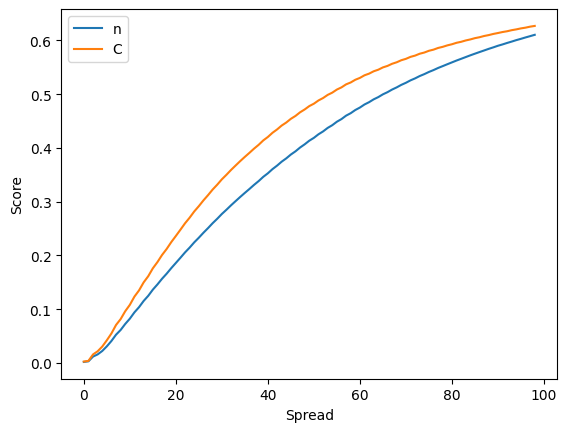

In [46]:
import pylab as plt
plt.plot(iou_mean1)
plt.xlabel('Spread')
plt.ylabel('Score')
plt.legend('nIoU')
plt.plot(cc_mean1)
plt.legend('nCC')
